In [1]:
%matplotlib inline

# Omori law statistics

Based on the following papers:
- Utsu, T., Ogata, Y., Matsu'ura, R. (1995), "The Centenary of the Omori Formula for a Decay Law of Aftershock Activity", *J. Phys. Earth*, **43**, 1-33 (https://www.jstage.jst.go.jp/article/jpe1952/43/1/43_1_1/_pdf)

In [33]:
import pylab
import numpy as np
import mapping.layeredbasemap as lbm
import eqcatalog
import hazard.rshalib as rshalib

The modified Omori law (*Utsu, 1961*) describes the power-law decay of aftershock rates following a mainshock:

$$N(t) = K(t+c)^{-p}$$

- $t$ : elapsed time since mainshock
- $N(t)$ : cumulative number of aftershocks
- $K$ : constant (slope)
- $p$ : power-law exponent (0.6 - 2.5 according to worldwide survey, with median ~1.1)
- $c$ : small positive constant (0.01 - 1 days)

Read earthquake sequence from database

In [3]:
cat = eqcatalog.rob.query_local_eq_catalog(start_date='2021-01-01', region=(6.0, 6.3, 50.58, 50.875))
cat.print_info()

+-------------------+-------------------------------------------------------+
|     Parameter     |                         Value                         |
+-------------------+-------------------------------------------------------+
|    Catalog name   | ROB Catalog 2021-01-01T00:00:00 - 2021-01-15T09:05:53 |
| Earthquake number |                           41                          |
|     Start time    |                2021-01-01T00:00:00.000                |
|      End time     |                2021-01-15T09:05:53.000                |
|  Longitude bounds |                    6.0260 / 6.2433                    |
|  Latitude bounds  |                   50.5898 / 50.8522                   |
|    Depth range    |                     7.9 / 15.8 km                     |
|         ML        |                n=41, min=-1.4, max=2.6                |
|    Event types    |                       ke (n=41)                       |
+-------------------+-------------------------------------------

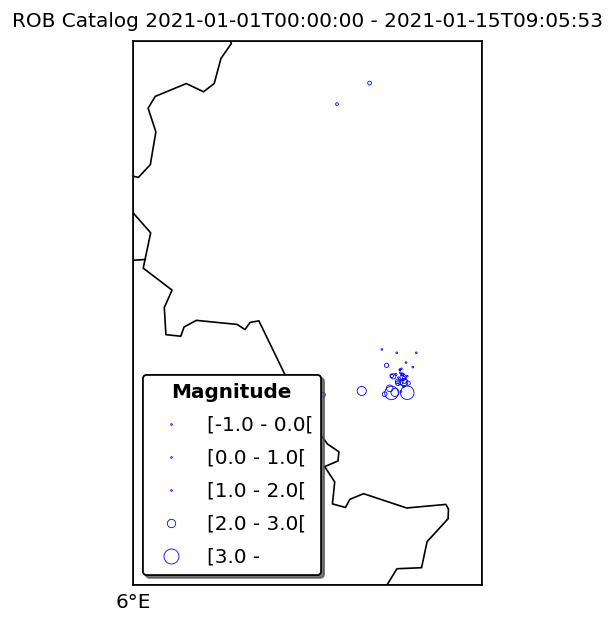

In [4]:
cat.plot_map(resolution='h')

Check if different declustering windows/methods identify sequence as 1 cluster

In [5]:
dc_method = eqcatalog.declustering.LinkedWindowMethod()

In [6]:
Mrelation = {'ML': 'GruenthalEtAl2009'}
for dc_window_name in ('GardnerKnopoff1974', 'Uhrhammer1986', 'Gruenthal2009'):
    print(dc_window_name)
    dc_window = eqcatalog.declustering.get_window_by_name(dc_window_name)
    dc_result = dc_method.analyze_clusters(cat, dc_window, Mrelation)
    dc_result.print_info()
    print()

GardnerKnopoff1974
Number of clusters identified: 2
Max. cluster length: 34
Num. clustered/unclustered events: 40 / 1
Num. dependent/independent events: 38 / 3

Uhrhammer1986
Number of clusters identified: 4
Max. cluster length: 14
Num. clustered/unclustered events: 20 / 21
Num. dependent/independent events: 16 / 25

Gruenthal2009
Number of clusters identified: 1
Max. cluster length: 41
Num. clustered/unclustered events: 41 / 0
Num. dependent/independent events: 40 / 1



In [7]:
dc_method = eqcatalog.declustering.ReasenbergMethod()
dc_window = eqcatalog.declustering.Reasenberg1985Window(dsigma=30, xmeff=1.5)
dc_result = dc_method.analyze_clusters(cat, Mrelation, dc_window, ignore_location_errors=False)
print('Reasenberg1985')
dc_result.print_info()

Reasenberg1985
Number of clusters identified: 1
Max. cluster length: 37
Num. clustered/unclustered events: 37 / 4
Num. dependent/independent events: 36 / 5


In [8]:
dc_result.get_unclustered_events().print_list()

+-------+------------+-----------------+--------------+-------+--------+------+------+
|    ID |    Date    |       Time      |     Name     |   Lon |    Lat |    Z |   ML |
+-------+------------+-----------------+--------------+-------+--------+------+------+
| 11740 | 2021-01-02 | 21:13:12.490000 |  ROTT (DE)   | 6.143 | 50.590 | 11.1 | -1.4 |
| 11665 | 2021-01-03 | 07:05:10.270000 | ALSDORF (DE) | 6.203 | 50.852 | 15.8 |  0.6 |
| 11685 | 2021-01-03 | 10:50:45.320000 | ALSDORF (DE) | 6.175 | 50.841 | 15.4 |  0.4 |
| 11885 | 2021-01-14 | 18:21:22.300000 |  ROTT (DE)   | 6.026 | 50.659 | 11.3 |  0.4 |
+-------+------------+-----------------+--------------+-------+--------+------+------+


Determine completeness magnitude Mc

Number of events constrained by completeness criteria: 28 out of 41


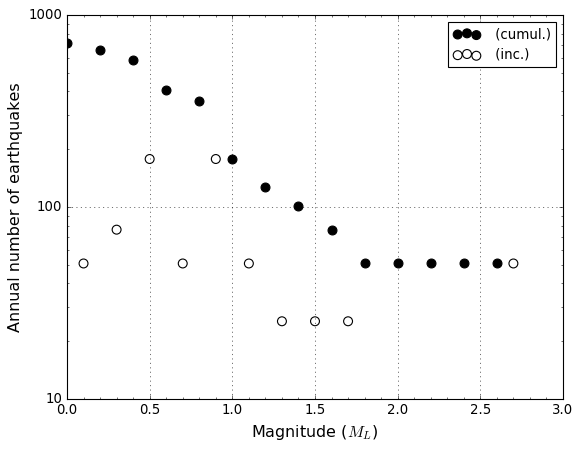

In [34]:
completeness = cat.get_uniform_completeness(0, Mtype='ML')
seq_mfd = cat.get_incremental_mfd(0, 3, 0.2, Mtype='ML', completeness=completeness)
seq_mfd.plot()

Mc can be estimated as 0.7 (0.3 if you are optimistic)

In [47]:
Mc = 0.3
#Mc = 0.7

Estimate parameters K, c, p of Omori law based on elapsed times since mainshock

In [30]:
mainshock = cat.get_event_by_id(11630)
Mm = mainshock.ML
mainshock.print_info()

+------------+-----------------+
| Attribute  |      Value      |
+------------+-----------------+
|     ID     |      11630      |
|    name    |    ROTT (DE)    |
|    date    |    2021-01-02   |
|    time    | 06:36:29.430000 |
|    lon     |      6.2355     |
|    lat     |     50.6843     |
|   depth    |       11.3      |
|     ML     |       2.6       |
|    errt    |       0.33      |
|    errh    |       0.5       |
|    errz    |       0.57      |
|    errM    |       0.2       |
|   agency   |       ROB       |
| event_type |        ke       |
+------------+-----------------+


In [13]:
cluster = dc_result.get_cluster_by_eq(mainshock)
aftershocks = cluster.get_aftershocks()
aftershocks.print_info()

+-------------------+--------------------------+
|     Parameter     |          Value           |
+-------------------+--------------------------+
|    Catalog name   | Cluster #0 (aftershocks) |
| Earthquake number |            32            |
|     Start time    | 2021-01-02T07:31:02.060  |
|      End time     | 2021-01-15T06:39:04.140  |
|  Longitude bounds |     6.1383 / 6.2433      |
|  Latitude bounds  |    50.6780 / 50.7078     |
|    Depth range    |      7.9 / 14.1 km       |
|         ML        | n=32, min=-0.9, max=2.6  |
|    Event types    |        ke (n=32)         |
+-------------------+--------------------------+


In [16]:
cc_aftershocks = aftershocks.subselect(Mmin=Mc, Mtype='ML')
print(len(cc_aftershocks))

19


Number of events constrained by completeness criteria: 18 out of 18
Number of events constrained by completeness criteria: 18 out of 18
<TruncatedGRMFD | ML=0.70:2.60:0.10 | a=3.10, b=0.81>


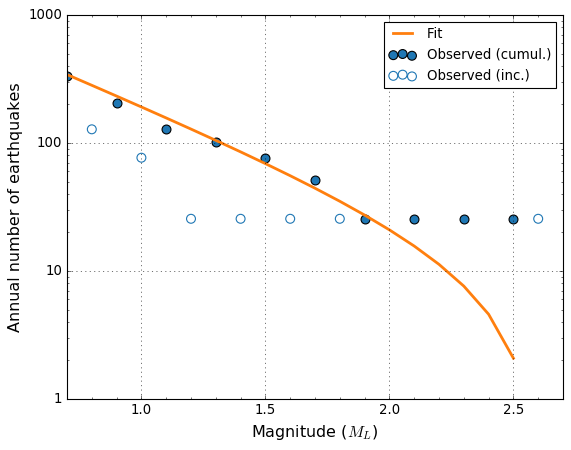

In [46]:
as_imfd = cc_aftershocks.get_incremental_mfd(0.7, Mm, Mtype='ML', completeness=completeness)
as_tmfd = cc_aftershocks.get_estimated_mfd(0.7, Mm, Mtype='ML', completeness=completeness)
print(as_tmfd)
rshalib.mfd.plot_mfds([as_imfd, as_tmfd], labels=['Observed', 'GR fit'])

In [48]:
as_time_deltas = cc_aftershocks.get_time_deltas(mainshock.datetime)
as_time_deltas = eqcatalog.time.fractional_time_delta(as_time_deltas, 'D')
as_time_deltas

array([  0.29376157,   0.33158565,   0.34032407,   0.34800926,
         0.75746528,   0.83662037,   0.96208333,   0.97803241,
         1.97284722,   2.91003472,   3.90126157,   4.195625  ,
         4.5047338 ,   5.84746528,   8.17983796,  11.75318287,
        12.47912037,  12.5724537 ,  13.00178241])

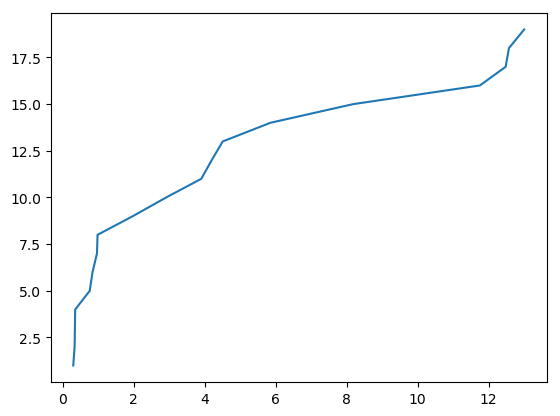

In [49]:
pylab.plot(as_time_deltas, np.arange(len(cc_aftershocks))+1)

In [50]:
(K, c, p) = eqcatalog.omori.estimate_omori_params(as_time_deltas)
print(K, c, p)

4.27267652643 0.391603067289 0.758493744699


C:\Miniconda3\envs\py3\lib\site-packages\scipy\optimize\_minimize.py:534: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


Note that value of K depends on completeness magnitude and mainshock magnitude, so these are inherent properties of the Omori law!

Define Omori law, including completeness magnitude and mainshock magnitude. Default time unit is days.

In [51]:
omlaw = eqcatalog.omori.OmoriLaw(K, c, p, Mc, Mm)

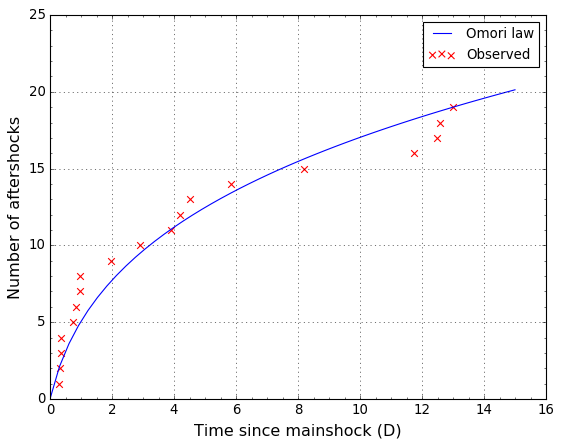

In [52]:
num_days = 15
x_values = np.linspace(0, num_days, 50)
omlaw.plot_cumulative(x_values, observed_delta_t=as_time_deltas, xscaling='lin')

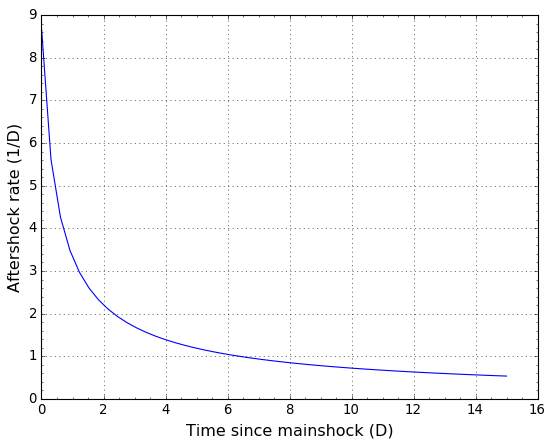

In [25]:
omlaw.plot_rate(x_values)

Assuming aftershock occurrence follows a **Poisson** probability model (see separate notebook), it is possible to compute probabilities and make some predictions. All predictions are valid for M>=Mc

In [53]:
end_time = 15
omlaw.get_num_aftershocks(end_time)

20.130758835776785

In [54]:
start_time = 10
end_time = 15
omlaw.get_num_aftershocks(end_time, start_time)

3.098822795582095

In [55]:
n = 1
start_time = 5
end_time = 6
omlaw.get_prob_n_aftershocks(n, end_time, start_time)

0.36563469860112069

In [56]:
start_time = 5
end_time = 6
omlaw.get_prob_one_or_more_aftershocks(end_time, start_time)

0.6720049617326409

In [57]:
n = 15
omlaw.get_time_delta_for_n_aftershocks(n)

7.466818805673453

To compute aftershock duration, we need to know the background rate. We estimate this from the entire catalog since 1985, convert to daily rate, and correct for area

In [59]:
full_cat = eqcatalog.read_named_catalog('ROB', verbose=False).subselect(start_date=1985)
full_cat.print_info()

+-------------------+-------------------------------------------------------------------+
|     Parameter     |                               Value                               |
+-------------------+-------------------------------------------------------------------+
|    Catalog name   | ROB Catalog 1350-01-01T00:00:00 - 2021-01-15T09:29:26 (subselect) |
| Earthquake number |                                2225                               |
|     Start time    |                      1985-01-01T00:00:00.000                      |
|      End time     |                      2021-01-15T09:29:26.000                      |
|  Longitude bounds |                          1.1700 / 8.0000                          |
|  Latitude bounds  |                         49.1630 / 51.9500                         |
|    Depth range    |                           0.0 / 42.6 km                           |
|         ML        |                     n=2187, min=-1.4, max=5.8                     |
|         

Determine Gutenberg-Richter relation for entire catalog. Note that b-value is very similar to that of the aftershock sequence!

Number of events constrained by completeness criteria: 2108 out of 2225
Number of events constrained by completeness criteria: 2108 out of 2225
<TruncatedGRMFD | ML=0.30:5.00:0.20 | a=2.51, b=0.78>


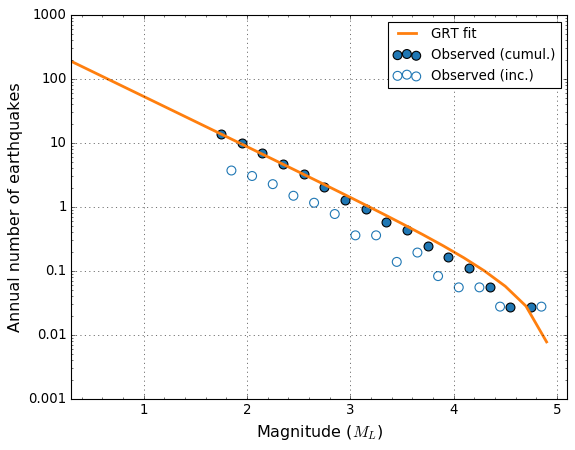

In [60]:
completeness = full_cat.get_uniform_completeness(0, Mtype='ML')
cat_imfd = full_cat.get_incremental_mfd(1.75, 5, 0.2, Mtype='ML', completeness=completeness)
cat_tmfd = full_cat.get_estimated_mfd(1.75, 5, 0.2, Mtype='ML', completeness=completeness)
cat_tmfd.min_mag = Mc
print(cat_tmfd)
rshalib.mfd.plot_mfds([cat_imfd, cat_tmfd], labels=['Observed', 'GRT fit'])

In [61]:
area_factor = (lbm.PolygonData.from_bbox(full_cat.get_region()).get_area()
               / lbm.PolygonData.from_bbox(cat.get_region()).get_area())
print(area_factor)

332.7989498209266


In [63]:
background_rate = cat_tmfd.get_cumulative_rates()[0]
background_rate /= 365
background_rate /= area_factor
print(background_rate)

0.00155465107308


In [64]:
#background_rate = 1./30
omlaw.get_aftershock_duration(background_rate)

34203.413067311914

We can do some predictions, but not about magnitude!

In order to do that, we need to combine the Omori law with the Gutenberg-Richter relation. This involves converting K to the magnitude-independent productivity parameter A.

Note that it would be better to convert ML to MW for this exercise

In [65]:
b_value = as_tmfd.b_val
gr_omlaw = omlaw.to_gr_omori_law(b_value)

In [66]:
gr_omlaw.K

4.2726765264282163

Now we can compute probabilities for higher Mc, simply by changing the Mc property of the Base10GROmoriLaw instance

In [67]:
gr_omlaw.Mc = 4
gr_omlaw.K

0.0042669379634756015

In [71]:
start_time = 13
end_time = start_time + 30
gr_omlaw.get_prob_one_or_more_aftershocks(end_time, start_time)

0.010796502723656287

What is the probability of an earthquake with $M_L \geq 2.6$ (mainshock magnitude) based on the first 12 days?

In [78]:
(K, c, p) = eqcatalog.omori.estimate_omori_params(as_time_deltas[as_time_deltas < 12])
print(K, c, p)

10.6047285803 1.15112659109 1.37433780908


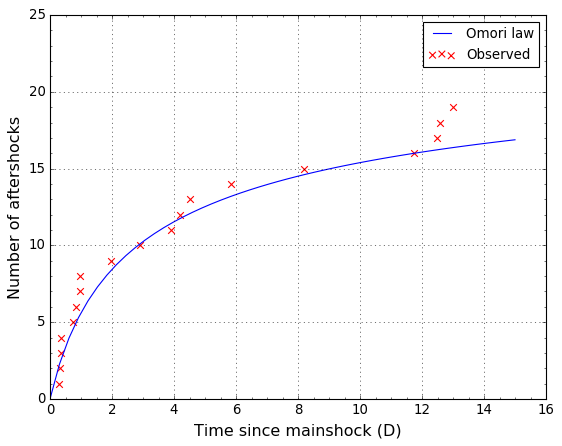

In [79]:
om_law2 = eqcatalog.omori.OmoriLaw(K, c, p, Mc, Mm)
gr_omlaw2 = om_law2.to_gr_omori_law(b_value)
gr_omlaw2.plot_cumulative(x_values, observed_delta_t=as_time_deltas, xscaling='lin')

In [86]:
gr_omlaw2.Mc = Mm
start_time = 12
end_time = start_time + 30
gr_omlaw2.get_prob_one_or_more_aftershocks(end_time, start_time)

0.051504985526051206

We can also simulate aftershock sequences or their properties

In [72]:
start_time = 13
end_time = start_time + 30
num_samples = 100
gr_omlaw.get_random_num_aftershocks(end_time, start_time, num_samples)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [73]:
gr_omlaw.Mc = 2
gr_omlaw.get_random_num_aftershocks(end_time, start_time, num_samples)

array([0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 2, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 3, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 2, 0])

In [74]:
duration = 100
gr_omlaw.get_random_time_deltas(duration)

array([ 13.97000358])

In [75]:
num_samples = 20
gr_omlaw.get_random_magnitudes(num_samples)

array([ 2.27691868,  2.49424755,  2.00144435,  2.19485452,  2.09409308,
        2.32747029,  2.57326904,  2.18969562,  2.05115165,  2.35513516,
        2.31554983,  2.18809331,  2.00662581,  2.29219519,  2.24089584,
        2.18788594,  2.08619145,  2.53847286,  2.05516925,  2.12746906])

In [76]:
duration = 100
Mmax = 6.0
for event in gr_omlaw.gen_aftershock_sequence(duration, etas=True, Mmax=Mmax):
    (delta_time, magnitude, index, parent_index) = event
    print('dt=%.2f days, M=%.2f, i=%d, parent=%d' % event)

dt=20.15 days, M=2.59, i=1, parent=0
dt=48.40 days, M=2.26, i=2, parent=0
dt=20.28 days, M=2.33, i=3, parent=1
dt=21.76 days, M=2.45, i=4, parent=1
dt=22.72 days, M=2.22, i=5, parent=4
dt=23.58 days, M=2.12, i=6, parent=5
dt=33.85 days, M=2.19, i=7, parent=5
dt=34.82 days, M=2.15, i=8, parent=7
dt=57.36 days, M=2.13, i=9, parent=7
dt=75.81 days, M=2.17, i=10, parent=7
dt=49.02 days, M=2.06, i=11, parent=8


In [77]:
gr_omlaw.Mc = 0.7
syncat = gr_omlaw.gen_aftershock_catalog(duration, mainshock=mainshock, etas=False, Mmax=Mmax)
syncat.print_list()

+----+------------+-----------------+--------------------+-------+--------+------+-----+
| ID |    Date    |       Time      |        Name        |   Lon |    Lat |    Z |  MW |
+----+------------+-----------------+--------------------+-------+--------+------+-----+
|  1 | 2021-01-03 | 01:07:02.970000 | AS #1 (parent: 0)  | 6.236 | 50.684 | 11.3 | 1.3 |
|  2 | 2021-01-06 | 11:42:08.334000 | AS #2 (parent: 0)  | 6.236 | 50.684 | 11.3 | 0.8 |
|  3 | 2021-01-13 | 01:54:15.166000 | AS #3 (parent: 0)  | 6.236 | 50.684 | 11.3 | 0.9 |
|  4 | 2021-01-15 | 07:02:52.341000 | AS #4 (parent: 0)  | 6.236 | 50.684 | 11.3 | 1.1 |
|  5 | 2021-01-15 | 09:40:08.014000 | AS #5 (parent: 0)  | 6.236 | 50.684 | 11.3 | 1.0 |
|  6 | 2021-01-18 | 14:48:52.188000 | AS #6 (parent: 0)  | 6.236 | 50.684 | 11.3 | 0.7 |
|  7 | 2021-01-27 | 22:58:24.950000 | AS #7 (parent: 0)  | 6.236 | 50.684 | 11.3 | 0.7 |
|  8 | 2021-01-29 | 14:39:02.290000 | AS #8 (parent: 0)  | 6.236 | 50.684 | 11.3 | 1.0 |
|  9 | 2021-01-30 | 0